In [28]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import unets_repo
from keras import backend as K
from scipy.stats import kurtosis, skew
from skimage.measure import shannon_entropy
import ast

In [31]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)
def batch_generator(suj_path, mask_path):
    suj_files = os.listdir(suj_path)
    indices = np.arange(len(suj_files))
    indices = np.random.permutation(indices)
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch=[]

train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))
val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))

Métricas con casteo a Double para calcular hard dice score a mano

In [32]:
def Dice(targets, inputs):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + K.epsilon()) / (K.sum(targets) + K.sum(inputs) + K.epsilon())

def Jaccard(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    
    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + K.epsilon())/(union + K.epsilon())

In [33]:
batch_size = 1
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
vspe = n_val_img//batch_size

Todos los modelos analizados

In [34]:
attunetselu = unets_repo.AttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
attunetselu.load_weights("modelsh5/0.8160_attunet_selu_lecun_aug_dicebce.h5")
unet3 = unets_repo.unet3plus(input_size=(256,256,1))
unet3.load_weights("modelsh5/0.5662_unet3plus_relu_aug_dicebce.h5")
vsunet = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=16)
vsunet.load_weights("modelsh5/0.8174_unet_v_small_selu_lecun_aug_dice.h5")
sunet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=32)
sunet.load_weights("modelsh5/0.7947_unet_small_relu_he_aug.h5")
unet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
unet.load_weights("modelsh5/0.8134_unet_relu_he_aug.h5")
unetselu = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
unetselu.load_weights("modelsh5/0.8314_unet_selu_lecun_aug_dicebce.h5")
restattunet = unets_repo.ResAttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64,bn=True)
restattunet.load_weights("modelsh5/0.8026_resattunet_selu_bn_dicebce.h5")
classicunet = unets_repo.classicUNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
classicunet.load_weights("modelsh5/0.8233_classicunet_selu_lecun_aug_dicebce.h5")
attunet = unets_repo.AttUnet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
attunet.load_weights("modelsh5/0.8042_attunet_relu_aug_dicebce.h5")

In [49]:
nets = [attunetselu,unet3,vsunet,sunet,unet,unetselu,restattunet,classicunet,attunet]
netnames = ["AttUnet w/s","Unet3+","vsUnet","sUnet","Unet","Unet w/s","ResAttUnet","ClassicUnet","AttUnet"]

#### Búsqueda de Thresholds:

In [ ]:
dices = []
for net in nets:
    dice = []
    for th in [0.05+0.05*i for i in range(19)]: #0.05-1
        dice_th = 0
        for _ in range(n_val_img):
            test_image_batch, test_mask_batch = val_gen_ds.__next__()
            test_img = test_image_batch[0]
            ground_truth = test_mask_batch[0]
            test_img_norm = test_img[:,:]
            test_img_input = np.expand_dims(test_img_norm, 0)
            prediction = nets[0](test_img_input).numpy()
            predicted_img_th = (prediction[0,:,:,0]>th)*1
            dice_th += Dice(ground_truth,predicted_img_th).numpy()
        dice.append(dice_th/n_val_img)
    dices.append(dice)

In [ ]:
with open('dices_by_th.txt', 'r') as file:
    dices = ast.literal_eval(file.read())
dices = [dice[0:-2] for dice in dices]
maxs = [max(d) for d in dices]
indices = [n.index(maxs[i])*0.05+0.05 for i,n in enumerate(dices)]
performance_modelos = dict(zip(netnames,maxs))

In [ ]:
plt.figure(figsize=(6,6))
for i,n in enumerate(dices):
    plt.plot(n,label=netnames[i])
    plt.xticks([0,5,10,15,19],[0.05,0.30,0.55,0.80,1.0])
    plt.legend()
    plt.xlabel("Threshold")
    plt.ylabel("Dice Score")
    #plt.title("p/set Validación")

In [47]:
#coeff =   [95, 123, 52, 131, 64, 76, 66, 89, 112] #cuantas fueron el mejor dice de las imagenes con prostata
#          [s,  r,   s,  r,   r,  s,  s,  s,  r]
       #  [90, 120, 47, 126, 60, 74, 62, 87, 107, 35]
#coeff_n = [559, 512, 554, 553, 556, 532, 537, 544, 545] # +1 si dijieron q es full background y era.
indices = [0.95, 0.45, 0.7, 0.65, 0.85, 0.95, 0.95, 0.95, 0.75]
#pond = np.add(coeff,coeff_n)

#todas nets = 0.859 th 0.5
#att unet x2 + unet3+ small = 0.859 th 0.4
#att w/s + unet3 + small = 0.857 th 0.5
#att w/s + unet3 + small + classic = 0.86 th 0.4

#### Búsqueda de coeficientes / performance por modelo:

Análisis sobre imágenes SIN próstata

In [ ]:
scores = [0]*len(nets2)
for _ in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    dice = 0
    if not np.any(ground_truth):
        for i,n in enumerate(nets):
            prediction = n(test_img_input).numpy()
            predicted_img_th = (prediction[0,:,:,0]>indices[i])*1
            dd = Dice(ground_truth,predicted_img_th).numpy()
            if dd == 1:
                scores[i]+=1
print(scores)

In [ ]:
scores3 = [0]*len(nets2)
for _ in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    dice = 0
    for i,n in enumerate(nets2):
        prediction = n(test_img_input).numpy()
        predicted_img_th = (prediction[0,:,:,0]>index[i])*1
        dd = Dice(ground_truth,predicted_img_th).numpy()
        if ((dd!=0) and (dd!=1)):
            if dd>dice:
                dice = dd
                max_i = i
    if dice > 0:
        scores3[max_i]+=1
print(scores3)

#### En conclusión quedaron 4 modelos:

In [50]:
nets2 = [nets[0],nets[1],nets[3],nets[7]]
index = [indices[0],indices[1],indices[3],indices[7]]
coeff2 = [169, 201, 228, 161] #0137

In [ ]:
dice3 = 0
for _ in range(n_val_img):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = np.zeros(shape=(1,256,256,256))
    for i,net in enumerate(nets):
        prediction += ((net(test_img_input).numpy())>index[i])*coeff2[i]/sum(coeff2)
    predicted_img_th = (prediction[0,:,:,0]>0.4)*1
    dice3 += Dice(ground_truth,predicted_img_th).numpy()
print(dice3/n_val_img) #0.86

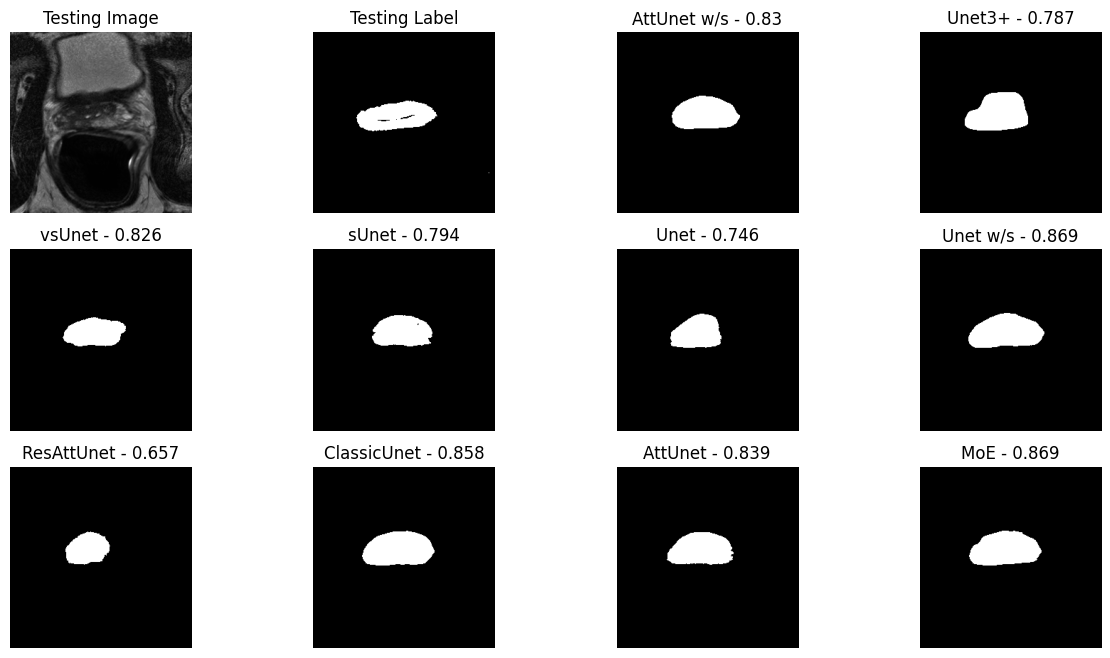

In [57]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img = test_image_batch[0]
ground_truth = test_mask_batch[0]
test_img_norm = test_img[:,:]
test_img_input = np.expand_dims(test_img_norm, 0)

plt.figure(figsize=(15,8))
plt.subplot(341)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.axis("off")
plt.subplot(342)
plt.title('Testing Label')
plt.imshow(ground_truth>0.5, cmap='gray')
plt.axis("off")
images = []
for i,n in enumerate(nets):
    prediction = n(test_img_input).numpy()
    prediction_th= (prediction[0,:,:,0]>indices[i])*1
    dice = Dice(ground_truth,prediction_th).numpy()
    plt.subplot(3,4,i+3)
    plt.title(netnames[i]+" - "+str(round(dice,3)))
    plt.imshow(prediction_th, cmap='gray')
    plt.axis("off")
    #images.append((prediction[0,:,:,0]>indices[i])*1)
prediction = np.zeros(shape=(1,256,256,256))
for i,net in enumerate(nets2):
    prediction += ((net(test_img_input).numpy())>index[i])*coeff2[i]/sum(coeff2)
predicted_img_th = (prediction[0,:,:,0]>0.4)*1
dice = Dice(ground_truth,predicted_img_th).numpy()
plt.subplot(3,4,12)
plt.title("MoE - "+str(round(dice,3)))
plt.imshow(predicted_img_th, cmap='gray')
plt.axis("off")
plt.show()

#### Búsqueda de TH dinámico a partir de características de imágenes de entrada
> Se descarta, media, std, sum(pixeles), histogram related, kurtosis, entropía, skewness, correlacion 2d. <br>
> No hay resultados viables, se propone usar threshold según dice score en validation set

In [ ]:
netnames = ["AttUnet w/s","Unet3+","sUnet","ClassicUnet"]
nets = [attunetselu,unet3,sunet,classicunet]
thresholds = [0.95,0.45,0.65,0.95] # th talque hard dice score es máx en set de validación
coeff = [169, 201, 228, 161] # cantidad de imágenes CON prostata donde obtuvieron mejor hard dice score
moe_th = 0.4 # th talque hard dice score es máx en set de validación
for unique in np.unique(prediction):
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = np.zeros(shape=(1,256,256,256))
    for i,net in enumerate(nets):
        prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff)
    predicted_img_th = (prediction[0,:,:,0] > unique)*1
    print(unique, Dice(ground_truth,predicted_img_th).numpy())
test_img_ravel = np.ravel(test_img)
cor = np.corrcoef(test_img)
cor_ravel = np.ravel(cor)
plt.hist(test_img_ravel,bins=1000)
plt.show()
print(np.sum(test_img_ravel))
print(kurtosis(test_img_ravel))
print(shannon_entropy(test_img))
print(skew(test_img_ravel))
plt.imshow(cor)
plt.show()
print(np.sum(cor_ravel))
print(kurtosis(cor_ravel))
print(shannon_entropy(cor))
print(skew(cor_ravel))